In [1]:
from google.colab import drive
drive.mount('/content/drive')

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms, datasets, models
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, precision_recall_curve
import torch.nn.functional as F


Mounted at /content/drive


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [3]:
import kagglehub
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

# Download dataset
path = kagglehub.dataset_download("alxmamaev/flowers-recognition")
print("Dataset Path:", path)

# The actual images are inside 'flowers'
data_dir = os.path.join(path, "flowers")
print("Data Directory:", data_dir)

# Transforms
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])

# Load full dataset
full_dataset = datasets.ImageFolder(root=data_dir, transform=transform)

# Split into Train (80%) and Validation (20%)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size

flower_train, flower_val = random_split(full_dataset, [train_size, val_size])

# DataLoaders
flower_train_loader = DataLoader(flower_train, batch_size=32, shuffle=True)
flower_val_loader = DataLoader(flower_val, batch_size=32, shuffle=False)

num_classes = len(full_dataset.classes)

print("Classes:", full_dataset.classes)
print("Number of classes:", num_classes)
print("Train size:", len(flower_train))
print("Validation size:", len(flower_val))


100%|██████████| 225M/225M [00:01<00:00, 154MB/s]

Extracting files...


Dataset Path: /root/.cache/kagglehub/datasets/alxmamaev/flowers-recognition/versions/2
Data Directory: /root/.cache/kagglehub/datasets/alxmamaev/flowers-recognition/versions/2/flowers
Classes: ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']
Number of classes: 5
Train size: 3453
Validation size: 864


In [4]:
# Make sure drive is mounted first
from google.colab import drive
drive.mount('/content/drive')

# Recreate EfficientNet architecture
from torchvision import models
import torch.nn as nn

def get_efficientnet(num_classes):
    model = models.efficientnet_b0(pretrained=False)
    model.classifier[1] = nn.Linear(
        model.classifier[1].in_features,
        num_classes
    )
    return model

# Create model
model_base = get_efficientnet(num_classes)

# Load saved weights
model_base.load_state_dict(
    torch.load("/content/drive/MyDrive/cnn_models/efficientnet_flower.pth",
               map_location=device)
)

model_base = model_base.to(device)
model_base.eval()

print("EfficientNet model loaded successfully.")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


EfficientNet model loaded successfully.


In [5]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
import seaborn as sns
from torchvision import models


In [6]:
def extract_features(model, loader):
    model.eval()
    features = []
    labels = []

    with torch.no_grad():
        for images, target in loader:
            images = images.to(device)

            # Extract features before classifier
            x = model.features(images)
            x = torch.nn.functional.adaptive_avg_pool2d(x, (1,1))
            x = torch.flatten(x, 1)

            features.append(x.cpu().numpy())
            labels.extend(target.numpy())

    features = np.vstack(features)
    labels = np.array(labels)

    return features, labels

features, labels = extract_features(model_base, flower_val_loader)

print("Feature shape:", features.shape)


Feature shape: (864, 1280)


# PCA Visualization

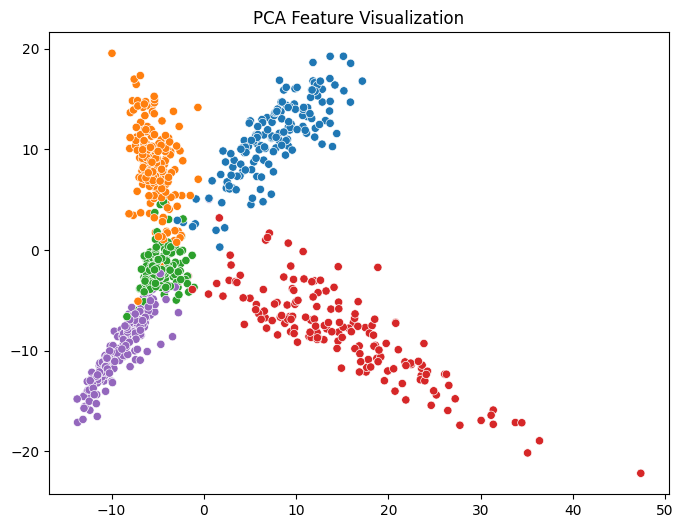

In [7]:
pca = PCA(n_components=2)
features_pca = pca.fit_transform(features)

plt.figure(figsize=(8,6))
sns.scatterplot(x=features_pca[:,0],
                y=features_pca[:,1],
                hue=labels,
                palette="tab10",
                legend=False)

plt.title("PCA Feature Visualization")
plt.show()


# t-SNE Visualization

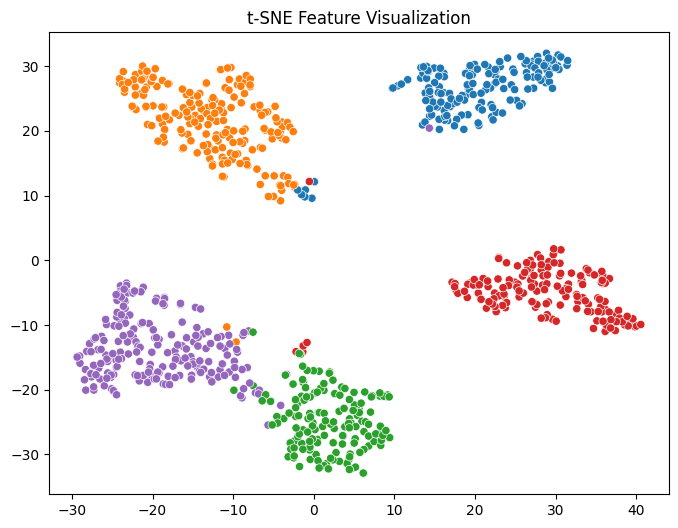

In [8]:
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
features_tsne = tsne.fit_transform(features)

plt.figure(figsize=(8,6))
sns.scatterplot(x=features_tsne[:,0],
                y=features_tsne[:,1],
                hue=labels,
                palette="tab10",
                legend=False)

plt.title("t-SNE Feature Visualization")
plt.show()


# UMAP Visualization

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


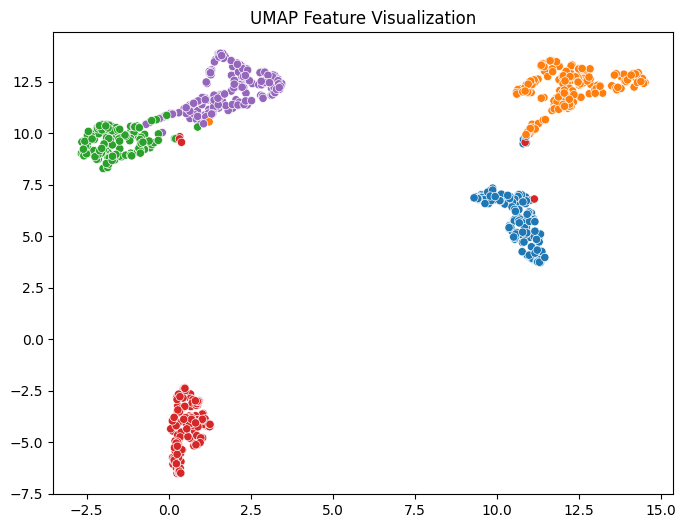

In [9]:
reducer = umap.UMAP(n_components=2, random_state=42)
features_umap = reducer.fit_transform(features)

plt.figure(figsize=(8,6))
sns.scatterplot(x=features_umap[:,0],
                y=features_umap[:,1],
                hue=labels,
                palette="tab10",
                legend=False)

plt.title("UMAP Feature Visualization")
plt.show()


# Minority Class Highlighting

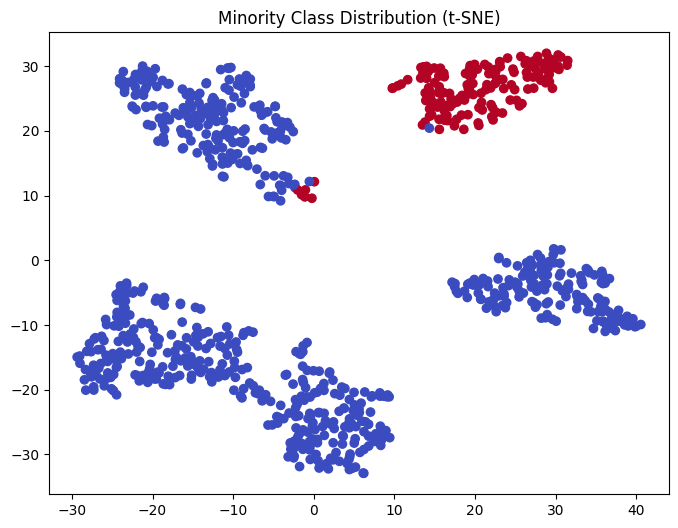

In [10]:
minority_class = np.argmin(np.bincount(labels))

plt.figure(figsize=(8,6))

plt.scatter(features_tsne[:,0],
            features_tsne[:,1],
            c=(labels == minority_class),
            cmap="coolwarm")

plt.title("Minority Class Distribution (t-SNE)")
plt.show()


# Grad-CAM

In [11]:
from torchvision.transforms.functional import to_pil_image
import cv2

def generate_gradcam(model, image, target_class):
    model.eval()

    gradients = []
    activations = []

    def backward_hook(module, grad_in, grad_out):
        gradients.append(grad_out[0])

    def forward_hook(module, input, output):
        activations.append(output)

    final_conv = model.features[-1]
    final_conv.register_forward_hook(forward_hook)
    final_conv.register_backward_hook(backward_hook)

    image = image.unsqueeze(0).to(device)
    output = model(image)
    model.zero_grad()

    loss = output[0, target_class]
    loss.backward()

    grad = gradients[0].cpu().data.numpy()[0]
    act = activations[0].cpu().data.numpy()[0]

    weights = np.mean(grad, axis=(1,2))
    cam = np.zeros(act.shape[1:], dtype=np.float32)

    for i, w in enumerate(weights):
        cam += w * act[i]

    cam = np.maximum(cam, 0)
    cam = cv2.resize(cam, (224,224))
    cam = cam / cam.max()

    return cam


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1866: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


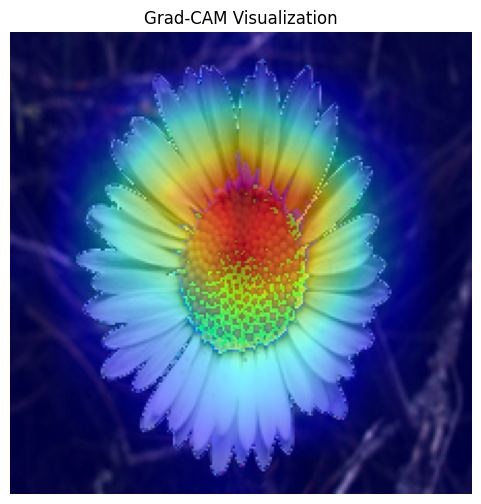

In [12]:
image, label = flower_val_loader.dataset[0]

cam = generate_gradcam(model_base, image, label)

plt.figure(figsize=(6,6))
plt.imshow(to_pil_image(image))
plt.imshow(cam, cmap='jet', alpha=0.5)
plt.title("Grad-CAM Visualization")
plt.axis('off')
plt.show()


# Inter-Class Separation Metric

In [13]:
from sklearn.metrics import pairwise_distances

class_centroids = []

for c in np.unique(labels):
    class_centroids.append(features[labels == c].mean(axis=0))

centroids = np.vstack(class_centroids)

distance_matrix = pairwise_distances(centroids)

print("Inter-class centroid distance matrix:")
print(distance_matrix)


Inter-class centroid distance matrix:
[[ 0.       25.766787 24.274199 27.245228 27.213346]
 [25.766787  0.       20.418713 26.739655 23.994112]
 [24.274199 20.418713  0.       24.47215  17.930424]
 [27.245228 26.739655 24.47215   0.       26.562716]
 [27.213346 23.994112 17.930424 26.562716  0.      ]]


# Intra-Class Compactness

In [14]:
intra_distances = []

for c in np.unique(labels):
    class_features = features[labels == c]
    centroid = class_features.mean(axis=0)
    distances = np.linalg.norm(class_features - centroid, axis=1)
    intra_distances.append(distances.mean())

print("Intra-class compactness per class:")
print(intra_distances)


Intra-class compactness per class:
[np.float32(12.310254), np.float32(9.830835), np.float32(7.9963913), np.float32(13.489579), np.float32(10.642028)]


# **part 6**






In [18]:
import kagglehub
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

intel_path = kagglehub.dataset_download("puneet6060/intel-image-classification")
print("Intel Dataset Path:", intel_path)

data_dir = os.path.join(intel_path, "seg_train")


Using Colab cache for faster access to the 'intel-image-classification' dataset.
Intel Dataset Path: /kaggle/input/intel-image-classification


In [23]:
intel_path = kagglehub.dataset_download("puneet6060/intel-image-classification")
print("Intel Dataset Path:", intel_path)

# Correct directory (double seg_train)
data_dir = os.path.join(intel_path, "seg_train", "seg_train")

print("Correct Data Directory:", data_dir)

intel_dataset = datasets.ImageFolder(
    root=data_dir,
    transform=transform_intel
)

train_size = int(0.8 * len(intel_dataset))
val_size = len(intel_dataset) - train_size

intel_train, intel_val = random_split(intel_dataset,
                                      [train_size, val_size])

intel_train_loader = DataLoader(intel_train,
                                batch_size=32,
                                shuffle=True)

intel_val_loader = DataLoader(intel_val,
                              batch_size=32,
                              shuffle=False)

num_intel_classes = len(intel_dataset.classes)

print("Intel Classes:", intel_dataset.classes)
print("Number of Classes:", num_intel_classes)



Using Colab cache for faster access to the 'intel-image-classification' dataset.
Intel Dataset Path: /kaggle/input/intel-image-classification
Correct Data Directory: /kaggle/input/intel-image-classification/seg_train/seg_train
Intel Classes: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
Number of Classes: 6


In [24]:
# Step 1: Load model with original Flower output size (5)
model_feature = get_efficientnet(5)

# Step 2: Load Flower-trained weights
model_feature.load_state_dict(
    torch.load("/content/drive/MyDrive/cnn_models/efficientnet_flower.pth",
               map_location=device)
)

# Step 3: Replace final classifier for Intel dataset
model_feature.classifier[1] = nn.Linear(
    model_feature.classifier[1].in_features,
    num_intel_classes
)

# Step 4: Freeze all layers except classifier
for param in model_feature.features.parameters():
    param.requires_grad = False

model_feature = model_feature.to(device)


In [25]:
# Step 1: Load Flower-trained model first
model_finetune = get_efficientnet(5)

model_finetune.load_state_dict(
    torch.load("/content/drive/MyDrive/cnn_models/efficientnet_flower.pth",
               map_location=device)
)

# Step 2: Replace classifier for Intel
model_finetune.classifier[1] = nn.Linear(
    model_finetune.classifier[1].in_features,
    num_intel_classes
)

# Step 3: Unfreeze all layers
for param in model_finetune.parameters():
    param.requires_grad = True

model_finetune = model_finetune.to(device)


In [26]:
import torch.optim as optim

def train_transfer(model, train_loader, val_loader, epochs=5):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train_losses = []
    val_losses = []

    for epoch in range(epochs):

        model.train()
        running_loss = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)

        # Validation
        model.eval()
        val_loss = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        val_loss = val_loss / len(val_loader)
        val_losses.append(val_loss)

        print(f"Epoch [{epoch+1}/{epochs}] "
              f"Train: {train_loss:.4f} "
              f"Val: {val_loss:.4f}")

    return train_losses, val_losses


In [27]:
print("Training Feature Extraction Model")
fe_train_loss, fe_val_loss = train_transfer(
    model_feature,
    intel_train_loader,
    intel_val_loader,
    epochs=5
)


Training Feature Extraction Model
Epoch [1/5] Train: 1.0106 Val: 0.7446
Epoch [2/5] Train: 0.7561 Val: 0.6291
Epoch [3/5] Train: 0.6765 Val: 0.5780
Epoch [4/5] Train: 0.6541 Val: 0.5783
Epoch [5/5] Train: 0.6258 Val: 0.5293


In [28]:
print("Training Fine-Tuning Model")
ft_train_loss, ft_val_loss = train_transfer(
    model_finetune,
    intel_train_loader,
    intel_val_loader,
    epochs=5
)


Training Fine-Tuning Model
Epoch [1/5] Train: 0.4261 Val: 0.2365
Epoch [2/5] Train: 0.2505 Val: 0.2641
Epoch [3/5] Train: 0.1969 Val: 0.2352
Epoch [4/5] Train: 0.1686 Val: 0.2315
Epoch [5/5] Train: 0.1422 Val: 0.2467


Performance Comparison

In [29]:
from sklearn.metrics import accuracy_score

def evaluate_transfer(model, loader):
    model.eval()
    preds = []
    labels_all = []

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            preds.extend(predicted.cpu().numpy())
            labels_all.extend(labels.numpy())

    return accuracy_score(labels_all, preds)

fe_acc = evaluate_transfer(model_feature, intel_val_loader)
ft_acc = evaluate_transfer(model_finetune, intel_val_loader)

print("Feature Extraction Accuracy:", fe_acc)
print("Fine-Tuning Accuracy:", ft_acc)


Feature Extraction Accuracy: 0.8140363377271108
Fine-Tuning Accuracy: 0.9266120413252583


Convergence Comparison


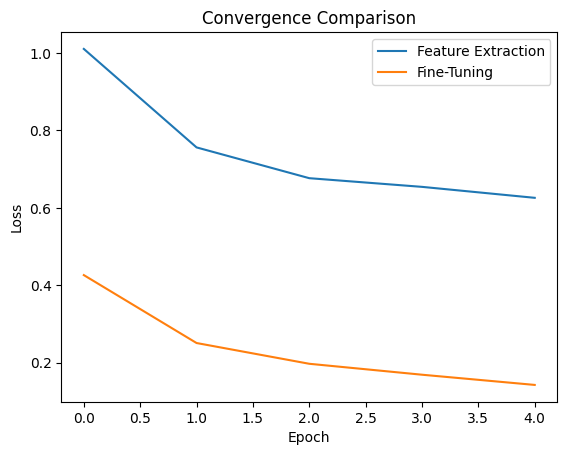

In [30]:
plt.plot(fe_train_loss, label="Feature Extraction")
plt.plot(ft_train_loss, label="Fine-Tuning")

plt.title("Convergence Comparison")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


Performance Degradation Analysis

In [31]:
# Flower validation accuracy
flower_acc = evaluate_transfer(model_base, flower_val_loader)

print("Flower Accuracy:", flower_acc)
print("Intel (Feature Extraction):", fe_acc)
print("Intel (Fine-Tuning):", ft_acc)

print("Performance Drop (Feature Extraction):",
      flower_acc - fe_acc)

print("Performance Drop (Fine-Tuning):",
      flower_acc - ft_acc)


Flower Accuracy: 0.9756944444444444
Intel (Feature Extraction): 0.8140363377271108
Intel (Fine-Tuning): 0.9266120413252583
Performance Drop (Feature Extraction): 0.1616581067173336
Performance Drop (Fine-Tuning): 0.0490824031191861


# **part 7**

In [32]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

def get_predictions(model, loader):
    model.eval()
    preds = []
    labels = []
    images_all = []

    with torch.no_grad():
        for images, target in loader:
            images = images.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            preds.extend(predicted.cpu().numpy())
            labels.extend(target.numpy())
            images_all.extend(images.cpu())

    return np.array(preds), np.array(labels), images_all

flower_preds, flower_labels, flower_images = get_predictions(
    model_base,
    flower_val_loader
)


Confusion Matrix (Flower)


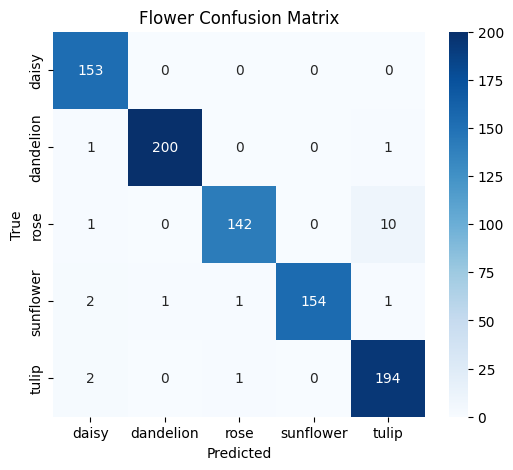

In [33]:
cm_flower = confusion_matrix(flower_labels, flower_preds)

plt.figure(figsize=(6,5))
sns.heatmap(cm_flower,
            annot=True,
            fmt="d",
            cmap="Blues",
            xticklabels=full_dataset.classes,
            yticklabels=full_dataset.classes)

plt.title("Flower Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


Identify Most Failed Classes (Flower)

In [34]:
class_errors = {}

for i, class_name in enumerate(full_dataset.classes):
    total = np.sum(flower_labels == i)
    correct = np.sum((flower_labels == i) & (flower_preds == i))
    error_rate = 1 - (correct / total)
    class_errors[class_name] = error_rate

print("Flower Class Error Rates:")
for k, v in class_errors.items():
    print(k, ":", round(v, 3))


Flower Class Error Rates:
daisy : 0.0
dandelion : 0.01
rose : 0.072
sunflower : 0.031
tulip : 0.015


In [35]:
flower_class_counts = np.bincount(
    [full_dataset.samples[i][1] for i in flower_train.indices]
)

print("Class Counts:", flower_class_counts)
print("Error Rates:", class_errors)


Class Counts: [611 850 631 574 787]
Error Rates: {'daisy': np.float64(0.0), 'dandelion': np.float64(0.00990099009900991), 'rose': np.float64(0.07189542483660127), 'sunflower': np.float64(0.03144654088050314), 'tulip': np.float64(0.015228426395939132)}


Visualize Misclassified Samples

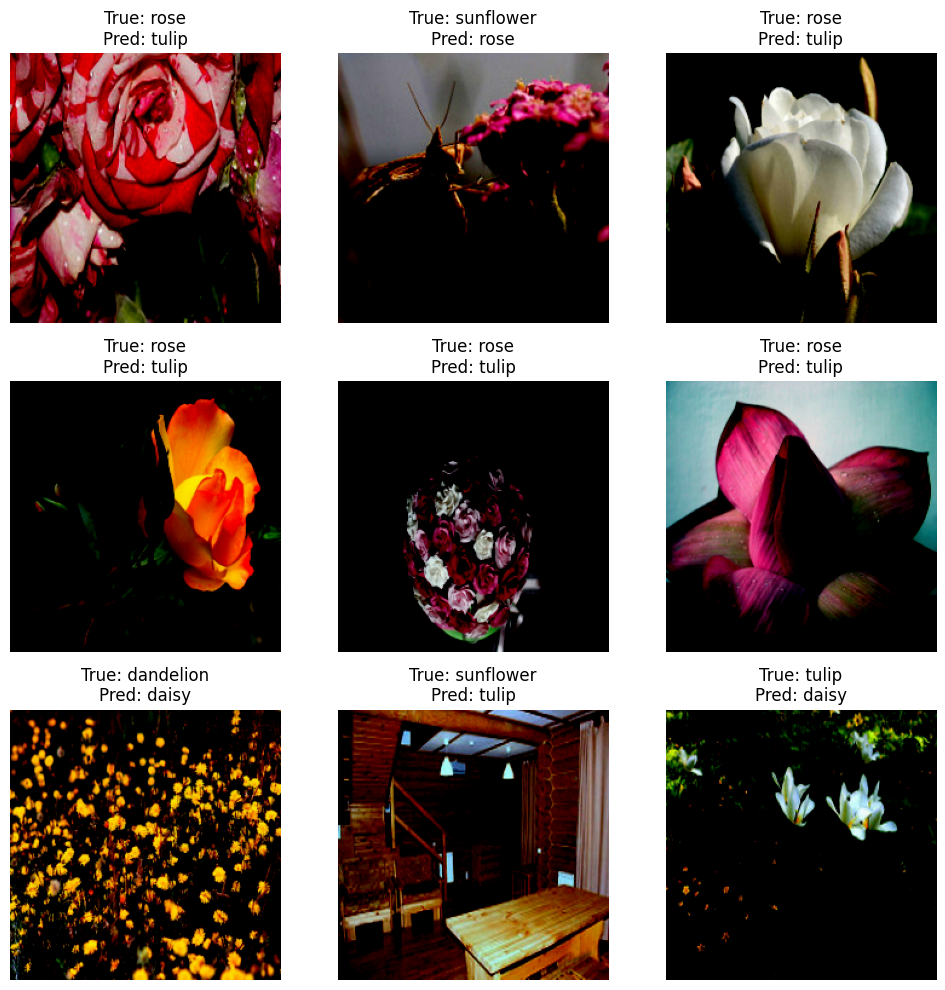

In [36]:
misclassified_idx = np.where(flower_preds != flower_labels)[0][:9]

plt.figure(figsize=(10,10))

for i, idx in enumerate(misclassified_idx):
    plt.subplot(3,3,i+1)
    img = flower_images[idx]
    plt.imshow(img.permute(1,2,0))
    plt.title(f"True: {full_dataset.classes[flower_labels[idx]]}\n"
              f"Pred: {full_dataset.classes[flower_preds[idx]]}")
    plt.axis("off")

plt.tight_layout()
plt.show()


In [37]:
intel_preds, intel_labels, intel_images = get_predictions(
    model_finetune,
    intel_val_loader
)


Confusion Matrix (Intel)

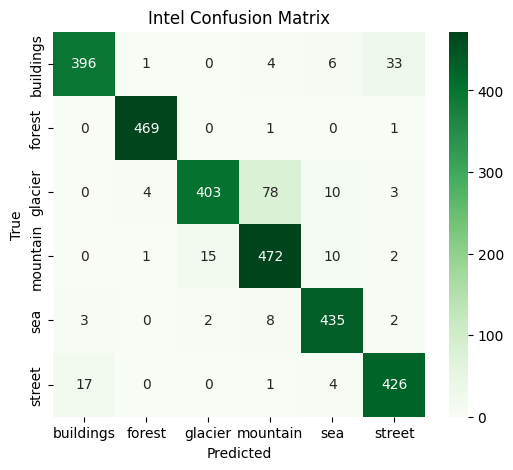

In [38]:
cm_intel = confusion_matrix(intel_labels, intel_preds)

plt.figure(figsize=(6,5))
sns.heatmap(cm_intel,
            annot=True,
            fmt="d",
            cmap="Greens",
            xticklabels=intel_dataset.classes,
            yticklabels=intel_dataset.classes)

plt.title("Intel Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


Identify Most Failed Intel Classes

In [39]:
intel_errors = {}

for i, class_name in enumerate(intel_dataset.classes):
    total = np.sum(intel_labels == i)
    correct = np.sum((intel_labels == i) & (intel_preds == i))
    error_rate = 1 - (correct / total)
    intel_errors[class_name] = error_rate

print("Intel Class Error Rates:")
for k, v in intel_errors.items():
    print(k, ":", round(v, 3))


Intel Class Error Rates:
buildings : 0.1
forest : 0.004
glacier : 0.191
mountain : 0.056
sea : 0.033
street : 0.049


Visualize Misclassified Intel Samples

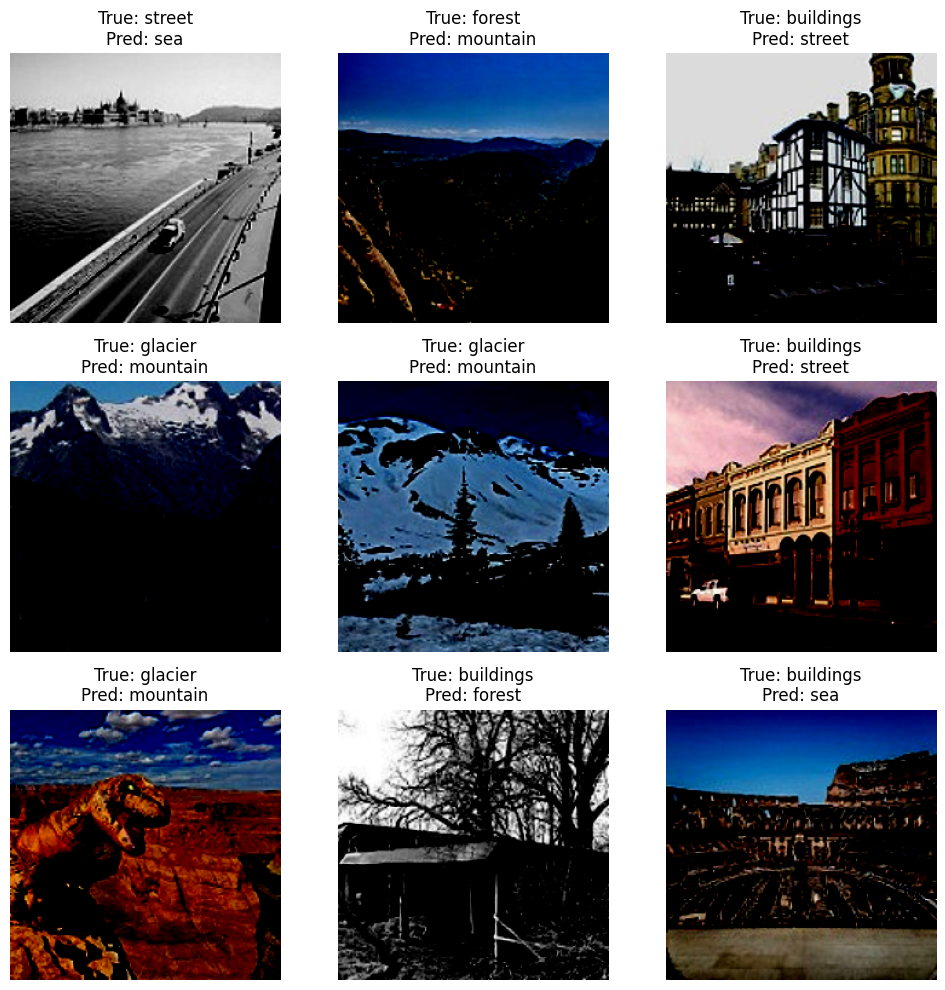

In [40]:
misclassified_intel = np.where(intel_preds != intel_labels)[0][:9]

plt.figure(figsize=(10,10))

for i, idx in enumerate(misclassified_intel):
    plt.subplot(3,3,i+1)
    img = intel_images[idx]
    plt.imshow(img.permute(1,2,0))
    plt.title(f"True: {intel_dataset.classes[intel_labels[idx]]}\n"
              f"Pred: {intel_dataset.classes[intel_preds[idx]]}")
    plt.axis("off")

plt.tight_layout()
plt.show()


Similar Class Confusion Pairs


In [41]:
def find_top_confusions(cm, class_names):
    confusions = []

    for i in range(len(cm)):
        for j in range(len(cm)):
            if i != j and cm[i][j] > 0:
                confusions.append(
                    (class_names[i],
                     class_names[j],
                     cm[i][j])
                )

    confusions = sorted(confusions,
                        key=lambda x: x[2],
                        reverse=True)

    return confusions[:5]

print("Top Flower Confusions:")
print(find_top_confusions(cm_flower, full_dataset.classes))

print("\nTop Intel Confusions:")
print(find_top_confusions(cm_intel, intel_dataset.classes))


Top Flower Confusions:
[('rose', 'tulip', np.int64(10)), ('sunflower', 'daisy', np.int64(2)), ('tulip', 'daisy', np.int64(2)), ('dandelion', 'daisy', np.int64(1)), ('dandelion', 'tulip', np.int64(1))]

Top Intel Confusions:
[('glacier', 'mountain', np.int64(78)), ('buildings', 'street', np.int64(33)), ('street', 'buildings', np.int64(17)), ('mountain', 'glacier', np.int64(15)), ('glacier', 'sea', np.int64(10))]
